1. Read data 

2. Prefix instructs

3. ICL Similar examples

4. Suffix Descriptions

Evaluation Method:

Validation: Sample 50

Test: Sample 500 repeat 5 times : mean std


1. Format: IUPAC name 

2. Similarity Methods

3. Temperature / Sample_N

Utils: Save during training

In [1]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
import os
import openai
import datetime
import numpy as np


def molToCanonical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol)
    return canonical_smiles

from steamship import Steamship

In [2]:
# Set up the OpenAI API client

openai.api_key = 'Your API Key'

In [3]:
ls Molecule_Design/ChEBI-20_data/

results/        results_test/   test.txt        train.txt       validation.txt


In [60]:
folder = 'Molecule_Design/ChEBI-20_data/'

In [5]:
ls Molecule_Design/ChEBI-20_data/

results/        results_test/   test.txt        train.txt       validation.txt


# Read data

In [6]:
import csv

In [7]:
def read_data(filename):
    # Open the file for reading
    with open(filename, 'r') as f:
        # Create a CSV reader with tab delimiter
        reader = csv.reader(f, delimiter='\t')
        # Read the data into a list of tuples
        data = [tuple(row) for row in reader]
    df = pd.DataFrame(data[1:], columns=data[0])
    return df

In [13]:
train = read_data(folder + "train.txt")
valid = read_data(folder + "validation.txt")
test = read_data(folder + "test.txt")

In [14]:
len(train)

26407

In [43]:
valid = valid.sample(30, random_state=42)

In [44]:
test = test.sample(500, random_state=42)

In [45]:
valid.columns

Index(['CID', 'SMILES', 'description'], dtype='object')

In [46]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm

def get_scaffold_fp(x):
    mol = Chem.MolFromSmiles(x)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    scaffold_fp = rdMolDescriptors.GetMorganFingerprint(scaffold, 2)
    return scaffold_fp

In [82]:
def molToCanonical(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol)
    return canonical_smiles

In [85]:
train['SMILES'] = train['SMILES'].apply(molToCanonical)

[14:14:56] WARNING: not removing hydrogen atom without neighbors
[14:14:56] WARNING: not removing hydrogen atom without neighbors
[14:14:56] WARNING: not removing hydrogen atom without neighbors
[14:14:56] WARNING: not removing hydrogen atom without neighbors
[14:14:57] WARNING: not removing hydrogen atom without neighbors
[14:14:57] WARNING: not removing hydrogen atom without neighbors
[14:14:57] WARNING: not removing hydrogen atom without neighbors
[14:14:57] WARNING: not removing hydrogen atom without neighbors
[14:14:57] WARNING: not removing hydrogen atom without neighbors
[14:14:58] WARNING: not removing hydrogen atom without neighbors
[14:14:58] WARNING: not removing hydrogen atom without neighbors
[14:14:59] WARNING: not removing hydrogen atom without neighbors
[14:14:59] WARNING: not removing hydrogen atom without neighbors
[14:14:59] WARNING: not removing hydrogen atom without neighbors
[14:14:59] WARNING: not removing hydrogen atom without neighbors
[14:15:00] WARNING: not r

In [88]:
valid['SMILES'] = valid['SMILES'].apply(molToCanonical)

In [89]:
test['SMILES'] = test['SMILES'].apply(molToCanonical)

In [90]:
train['scaffold_fp'] = train['SMILES'].apply(lambda x: get_scaffold_fp(x))

[14:15:50] WARNING: not removing hydrogen atom without neighbors
[14:15:50] WARNING: not removing hydrogen atom without neighbors
[14:15:50] WARNING: not removing hydrogen atom without neighbors
[14:15:51] WARNING: not removing hydrogen atom without neighbors
[14:15:52] WARNING: not removing hydrogen atom without neighbors
[14:15:52] WARNING: not removing hydrogen atom without neighbors
[14:15:52] WARNING: not removing hydrogen atom without neighbors
[14:15:53] WARNING: not removing hydrogen atom without neighbors
[14:15:53] WARNING: not removing hydrogen atom without neighbors
[14:15:54] WARNING: not removing hydrogen atom without neighbors
[14:15:54] WARNING: not removing hydrogen atom without neighbors
[14:15:56] WARNING: not removing hydrogen atom without neighbors
[14:15:56] WARNING: not removing hydrogen atom without neighbors
[14:15:57] WARNING: not removing hydrogen atom without neighbors
[14:15:57] WARNING: not removing hydrogen atom without neighbors
[14:15:58] WARNING: not r

In [48]:
def top_n_scaffold_similar_molecules(target_smiles, molecule_scaffold_list, molecule_smiles_list, n=5):
    target_mol = Chem.MolFromSmiles(target_smiles)
    target_scaffold = MurckoScaffold.GetScaffoldForMol(target_mol)
    target_fp = rdMolDescriptors.GetMorganFingerprint(target_scaffold, 2)

    similarities = []

    for idx, scaffold_fp in enumerate(molecule_scaffold_list):
        try:
            tanimoto_similarity = DataStructs.TanimotoSimilarity(target_fp, scaffold_fp)
            similarities.append((idx, tanimoto_similarity))
        except Exception as e:
            print(e)
            continue

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_5_similar_molecules = similarities[:n]

    return [molecule_smiles_list[i[0]] for i in top_5_similar_molecules]

In [49]:
# top_n_scaffold_similar_molecules(train.iloc[0]['reactants_smiles'], list(train['scaffold_fp']), list(train['reactants_smiles']))

# Prompt

In [63]:
# 1. prompt
# 2. performance csv
# 3. sleep 

In [73]:
def create_prompt_molecule_design(input_text, examples):
    prompt = "You are an expert chemist. Given the molecular requirements description, your task is to design a new molecule using your experienced chemical Molecular Design knowledge. \n\
Please strictly follow the format, no other information can be provided. You should only reply with SMILES \
string notations to represent the designed molecule. The SMILES must be valid and chemically reasonable. \n"
    
    for example in examples:
        prompt += f"Molecular requirements description: {example[0]}\nMolecular SMILES: {example[1]}\n"
    prompt += f"Molecular requirements description: {input_text}\nMolecular SMILES:"
    return prompt

In [74]:
def create_prompt_molecule_captioning(input_text, examples):
    prompt = "You are an expert chemist. Given the molecular SMILES, your task is to provide the detailed description of the molecule using your experienced chemical Molecular knowledge. \n\
Please strictly follow the format, no other information can be provided.\n"
    
    for example in examples:
        prompt += f"Molecule SMILES: {example[0]}\nMolecular Description: {example[1]}\n"
    prompt += f"Molecule SMILES: {input_text}\nMolecular Description:"
    return prompt

# Validation

In [66]:
from prompt_utils.icl_examples import *

In [78]:
import time

In [79]:
def generate_response_by_davinci(prompt, model_engine = 'text-davinci-003'):
    time.sleep(2)
    completion = openai.Completion.create(
      engine=model_engine,
      prompt=prompt,
      temperature=0.5,
      max_tokens=256,
#       top_p=1.0,
      frequency_penalty=0.0,
      presence_penalty=0.0, 
      n=5,
    )
#     message = completion.choices[0]['text'].strip()
    
    message = completion.choices
    message = [i['text'].strip() for i in message]
    return message

def generate_response_by_gpt35(prompt, model_engine = "gpt-3.5-turbo"):
    time.sleep(2)
    completion = openai.ChatCompletion.create(
        model=model_engine, temperature=0.5, n=5, 
        messages=[{"role": "user", "content": prompt}],
    )
#     message = completion.choices[0].message.content.strip()

    message = completion.choices
    message = [i.message.content.strip() for i in message]
    return message

def generate_response_by_gpt4(prompt):
    time.sleep(2)
    # Create a Steamship client
    # NOTE: When developing a package, just use `self.client`
    client = Steamship(workspace="gpt-4-92g")

    # Create an instance of this generator
    generator = client.use_plugin('gpt-4', config={"temperature":0.5, "n": 5})

    # Generate text
    task = generator.generate(text=prompt)
    # Wait for completion of the task.
    task.wait()
    # Print the output
#     message = task.output.blocks[0].text.strip()
    message = task.output.blocks
    message = [i.text.strip() for i in message]
    return message

In [68]:
def get_input_output_columns_by_task(task):
    if task == 'smiles2iupac':
        return "smiles", "iupac"
    elif task == 'smiles2formula':
        return "smiles", "formula"
    elif task == 'iupac2smiles':
        return "iupac", "smiles"
    elif task == 'formula2smiles':
        return "formula", 'smiles'
    elif task == 'molecule_design':
        return "description", "SMILES"
    elif task == 'molecule_captioning':
        return "SMILES", "description"

In [69]:
def create_prompt(reactant, examples, task):
    if task == 'smiles2iupac':
        return create_prompt_smiles2iupac(reactant, examples)
    elif task == 'smiles2formula':
        return create_prompt_smiles2formula(reactant, examples)
    elif task == 'iupac2smiles':
        return create_prompt_iupac2smiles(reactant, examples)
    elif task == 'formula2smiles':
        return create_prompt_formula2smiles(reactant, examples)
    elif task == 'molecule_design':
        return create_prompt_molecule_design(reactant, examples)
    elif task == 'molecule_captioning':
        return create_prompt_molecule_captioning(reactant, examples)

In [62]:
import difflib

def similarity_ratio(s1, s2):
    # Calculate the similarity ratio between the two strings
    ratio = difflib.SequenceMatcher(None, s1, s2).ratio()
    
    # Return the similarity ratio
    return ratio

# Example usage:
s1 = "python"
s2 = "pathon"
ratio = similarity_ratio(s1, s2)
print(ratio)  # Output: 0.0


def top_n_similar_strings(query, candidates, n=5):
    # Calculate the Levenshtein distance between the query and each candidate
    distances = [(c, similarity_ratio(query, c)) for c in candidates]
    
    # Sort the candidates by their Levenshtein distance to the query
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=True)
    
    # Get the top n candidates with the smallest Levenshtein distance
    top_candidates = [d[0] for d in sorted_distances[:n]]
    
    # Return the top n candidates
    return top_candidates
top_n_similar_strings("pathon", ['python', 'java'])

0.8333333333333334


['python', 'java']

In [96]:
# format the running grid search 
# evaluate and save

Models = ['davinci003', 'gpt4', 'gpt35']
ICL_Sample_methods = ['Scaffold_SIM', 'Fixed_ICL']
ICL_Samples = [5, 10]
NAME_Format = ['SMILES']
TASK_Types = ['molecule_captioning', 'molecule_design']
detail_save_folder = folder + '/results/'

params_idx = 0

for sample_method in ICL_Sample_methods:
    for sample_num in ICL_Samples:
        for name in NAME_Format:
            for task in TASK_Types:
                for model in Models:
                    
                    details_results = []
                    performance_results = []
                                      
                    if params_idx < 14:
                        params_idx +=1
                        continue
                    
                    detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
                    log_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.log'.format(task, model, name, sample_num, sample_method)
                    print(detail_predict_file)

                    # append new date
                    # Get the current date and time
                    now = datetime.datetime.now()
                    # Convert the date and time to a string
                    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
                    with open(log_file, "w+") as file:
                        file.write("=" * 30 + date_time_str + "=" * 30 + "\n")

                    # init var
                    predicted_products = []
                    input_col, output_col = get_input_output_columns_by_task(task)

                    # query
                    for idx, row in tqdm(valid.iterrows()):
                        reactant = row[input_col]
                        product = row[output_col]

                        # ICL examples
                        if sample_method == 'Fixed_ICL':
                            chunk = train.sample(sample_num, random_state=42)
                        elif sample_method == 'Scaffold_SIM':
                            if input_col == 'SMILES':
                                sim = top_n_scaffold_similar_molecules(reactant, list(train['scaffold_fp']), list(train['SMILES']), n=sample_num)
                            else:
                                # similarity by leven
                                sim = top_n_similar_strings(reactant, list(train[input_col]), n=sample_num)
                            chunk = train[train[input_col].isin(sim)]
                            
                        examples = list(zip(chunk[input_col].values, chunk[output_col].values))

                        # build prompt and save
                        prompt = create_prompt(reactant, examples, task)
                        
                        with open(log_file, "a") as file:
                            file.write(prompt + "\n")
                            file.write("=" * 50 + "\n")

                        # different model 
                        if model == 'davinci003':
                            predicted_product = generate_response_by_davinci(prompt)
                        elif model == 'gpt35':
                            predicted_product = generate_response_by_gpt35(prompt)
                        elif model == 'gpt4':
                            predicted_product = generate_response_by_gpt4(prompt)

                        predicted_products.append(predicted_product)
                        details_results.append([reactant] + [product] + predicted_product)

#                     # evaluate
#                     acc_list = []
#                     for repeat in range(5):
#                         tpredicted_products = [i[repeat] for i in predicted_products]
#                         correct = 0
#                         all_sample_num = len(valid)
#                         for idx, gt in enumerate(list(valid['products_smiles'])):
#                             pred = tpredicted_products[idx]
#                             try:
#                                 mol = Chem.MolFromSmiles(pred)
#                                 pred = Chem.MolToSmiles(mol)
#                             except Exception as e:
#                                 continue

#                             pred_list = pred.split(".")
#                             if gt in pred_list:
#                                 correct += 1
#                         acc = correct / all_sample_num
#                         acc_list.append(acc)

                    # save to file
#                     performance_results.append([task, model, name, sample_num, sample_method, np.mean(acc_list)] + acc_list)

                    details_df = pd.DataFrame(details_results, columns=[input_col, output_col, 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'])
                    details_df.to_csv(detail_predict_file, index=False)
           
                    params_idx += 1
                    print(params_idx)

Molecule_Design/ChEBI-20_data//results/valid_molecule_captioning_gpt35_SMILES_5_Fixed_ICL.csv


30it [06:54, 13.80s/it]


15
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_davinci003_SMILES_5_Fixed_ICL.csv


30it [05:45, 11.51s/it]


16
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_gpt4_SMILES_5_Fixed_ICL.csv


30it [06:55, 13.85s/it]


17
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_gpt35_SMILES_5_Fixed_ICL.csv


30it [04:31,  9.05s/it]


18
Molecule_Design/ChEBI-20_data//results/valid_molecule_captioning_davinci003_SMILES_10_Fixed_ICL.csv


30it [07:41, 15.40s/it]


19
Molecule_Design/ChEBI-20_data//results/valid_molecule_captioning_gpt4_SMILES_10_Fixed_ICL.csv


30it [11:05, 22.19s/it]


20
Molecule_Design/ChEBI-20_data//results/valid_molecule_captioning_gpt35_SMILES_10_Fixed_ICL.csv


30it [07:17, 14.59s/it]


21
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_davinci003_SMILES_10_Fixed_ICL.csv


30it [06:21, 12.72s/it]


22
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_gpt4_SMILES_10_Fixed_ICL.csv


30it [07:02, 14.08s/it]


23
Molecule_Design/ChEBI-20_data//results/valid_molecule_design_gpt35_SMILES_10_Fixed_ICL.csv


30it [08:28, 16.96s/it]

24


# Eval

In [114]:
from nltk.translate.bleu_score import corpus_bleu
from Levenshtein import distance as lev
def evaluate1(outputs, verbose=False):
#     outputs = []

#     with open(osp.join(input_fp)) as f:
#         reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
#         for n, line in enumerate(reader):
#             gt_smi = line['ground truth']
#             ot_smi = line['output']
#             outputs.append((line['description'], gt_smi, ot_smi))


    bleu_scores = []
    #meteor_scores = []

    references = []
    hypotheses = []

    for i, (smi, gt, out) in enumerate(outputs):

        if i % 100 == 0:
            if verbose:
                print(i, 'processed.')


        gt_tokens = [c for c in gt]

        out_tokens = [c for c in out]

        references.append([gt_tokens])
        hypotheses.append(out_tokens)

        # mscore = meteor_score([gt], out)
        # meteor_scores.append(mscore)

    # BLEU score
    bleu_score = corpus_bleu(references, hypotheses)
    if verbose: print('BLEU score:', bleu_score)

    # Meteor score
    # _meteor_score = np.mean(meteor_scores)
    # print('Average Meteor score:', _meteor_score)

    rouge_scores = []

    references = []
    hypotheses = []

    levs = []

    num_exact = 0

    bad_mols = 0

    for i, (smi, gt, out) in enumerate(outputs):

        hypotheses.append(out)
        references.append(gt)

        try:
            m_out = Chem.MolFromSmiles(out)
            m_gt = Chem.MolFromSmiles(gt)

            if Chem.MolToInchi(m_out) == Chem.MolToInchi(m_gt): num_exact += 1
            #if gt == out: num_exact += 1 #old version that didn't standardize strings
        except:
            bad_mols += 1

        

        levs.append(lev(out, gt))


    # Exact matching score
    exact_match_score = num_exact/(i+1)
    if verbose:
        print('Exact Match:')
        print(exact_match_score)

    # Levenshtein score
    levenshtein_score = np.mean(levs)
    if verbose:
        print('Levenshtein:')
        print(levenshtein_score)
        
    validity_score = 1 - bad_mols/len(outputs)
    if verbose:
        print('validity:', validity_score)

    return bleu_score, exact_match_score, levenshtein_score, validity_score

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
from rdkit.Chem import AllChem

def evaluate2(raw_outputs, morgan_r=2, verbose=False):
    bad_mols = 0
    outputs = []

    for desc, gt_smi, ot_smi in raw_outputs:
        try:
            gt_m = Chem.MolFromSmiles(gt_smi)
            ot_m = Chem.MolFromSmiles(ot_smi)

            if ot_m == None: raise ValueError('Bad SMILES')
            outputs.append((desc, gt_m, ot_m))
        except:
            bad_mols += 1
    validity_score = len(outputs)/(len(outputs)+bad_mols)
    if verbose:
        print('validity:', validity_score)


    MACCS_sims = []
    morgan_sims = []
    RDK_sims = []

    enum_list = outputs

    for i, (desc, gt_m, ot_m) in enumerate(enum_list):

        if i % 100 == 0:
            if verbose: print(i, 'processed.')

        MACCS_sims.append(DataStructs.FingerprintSimilarity(MACCSkeys.GenMACCSKeys(gt_m), MACCSkeys.GenMACCSKeys(ot_m), metric=DataStructs.TanimotoSimilarity))
        RDK_sims.append(DataStructs.FingerprintSimilarity(Chem.RDKFingerprint(gt_m), Chem.RDKFingerprint(ot_m), metric=DataStructs.TanimotoSimilarity))
        morgan_sims.append(DataStructs.TanimotoSimilarity(AllChem.GetMorganFingerprint(gt_m,morgan_r), AllChem.GetMorganFingerprint(ot_m, morgan_r)))

    maccs_sims_score = np.mean(MACCS_sims)
    rdk_sims_score = np.mean(RDK_sims)
    morgan_sims_score = np.mean(morgan_sims)
    if verbose:
        print('Average MACCS Similarity:', maccs_sims_score)
        print('Average RDK Similarity:', rdk_sims_score)
        print('Average Morgan Similarity:', morgan_sims_score)
    return validity_score, maccs_sims_score, rdk_sims_score, morgan_sims_score

from fcd import get_fcd, load_ref_model, canonical_smiles

def evaluate3(gt_smis, ot_smis, verbose=False):
#     gt_smis = []
#     ot_smis = []

#     with open(osp.join(input_file)) as f:
#         reader = csv.DictReader(f, delimiter="\t", quoting=csv.QUOTE_NONE)
#         for n, line in enumerate(reader):
#             gt_smi = line['ground truth']
#             ot_smi = line['output']
#             if len(ot_smi) == 0: ot_smi = '[]'

#             gt_smis.append(gt_smi)
#             ot_smis.append(ot_smi)


    model = load_ref_model()

    canon_gt_smis = [w for w in canonical_smiles(gt_smis) if w is not None]
    canon_ot_smis = [w for w in canonical_smiles(ot_smis) if w is not None]

    fcd_sim_score = get_fcd(canon_gt_smis, canon_ot_smis, model)
    if verbose:
        print('FCD Similarity:', fcd_sim_score)

    return fcd_sim_score

## Molecule Design

In [95]:
def evaluate_one_molecule_design(details_df):
    bleu_scores = []
    exact_match_scores = []
    levenshtein_scores = []
    validity_scores = []
    maccs_sims_scores = []
    rdk_sims_scores = []
    morgan_sims_scores = []
    fcd_scores = []

    fcds = []
    
    for i in range(1, 6):
        tem = list(zip(details_df['description'], details_df['SMILES'], details_df['pred_{}'.format(i)]))
#         tem2 = list(zip(details_df['SMILES'], details_df['pred_{}'.format(i)]))
        
        bleu_score, exact_match_score, levenshtein_score, _ = evaluate1(tem)
        validity_score, maccs_sims_score, rdk_sims_score, morgan_sims_score = evaluate2(tem)
        fcd = evaluate3(list(details_df['SMILES']), list(details_df['pred_{}'.format(i)]))
        
        bleu_scores.append(bleu_score)
        exact_match_scores.append(exact_match_score)
        levenshtein_scores.append(levenshtein_score)
        
        validity_scores.append(validity_score)
        maccs_sims_scores.append(maccs_sims_score)
        rdk_sims_scores.append(rdk_sims_score)
        morgan_sims_scores.append(morgan_sims_score)
        
        fcd_scores.append(fcd)
    
    bleu_mean = np.mean(bleu_scores)
    exact_match_mean = np.mean(exact_match_scores)
    levenshtein_mean = np.mean(levenshtein_scores)
    validity_mean = np.mean(validity_scores)
    maccs_sims_mean = np.mean(maccs_sims_scores)
    rdk_sims_mean = np.mean(rdk_sims_scores)
    morgan_sims_mean = np.mean(morgan_sims_scores)
    fcd_mean = np.mean(fcd_scores)
    

    # cal std
    bleu_variance = statistics.stdev(bleu_scores)
    exact_match_variance = statistics.stdev(exact_match_scores) 
    levenshtein_variance = statistics.stdev(levenshtein_scores)
    validity_variance = statistics.stdev(validity_scores)
    maccs_sims_variance = statistics.stdev(maccs_sims_scores) 
    rdk_sims_variance = statistics.stdev(rdk_sims_scores) 
    morgan_sims_variance = statistics.stdev(morgan_sims_scores) 
    fcd_variance = statistics.stdev(fcd_scores) 
    
    stds = [bleu_variance, exact_match_variance, levenshtein_variance, 
             validity_variance, maccs_sims_variance, rdk_sims_variance, 
             morgan_sims_variance, fcd_variance]
    
    return [bleu_mean, exact_match_mean, levenshtein_mean, validity_mean, maccs_sims_mean, rdk_sims_mean, morgan_sims_mean, fcd_mean], stds 

In [41]:
from transformers import BertTokenizerFast

from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

def evaluate4(raw_outputs, text_model='allenai/scibert_scivocab_uncased', text_trunc_length=512):
    outputs = []
    
    for smiles, gt, output in raw_outputs:
        out_tmp = output[6:] if output.startswith('[CLS] ') else output
        outputs.append((smiles, gt, out_tmp))

    text_tokenizer = BertTokenizerFast.from_pretrained(text_model)

    bleu_scores = []
    meteor_scores = []

    references = []
    hypotheses = []

    for i, (smi, gt, out) in enumerate(outputs):

        if i % 100 == 0: pass


        gt_tokens = text_tokenizer.tokenize(gt, truncation=True, max_length=text_trunc_length,
                                            padding='max_length')
        gt_tokens = list(filter(('[PAD]').__ne__, gt_tokens))
        gt_tokens = list(filter(('[CLS]').__ne__, gt_tokens))
        gt_tokens = list(filter(('[SEP]').__ne__, gt_tokens))

        out_tokens = text_tokenizer.tokenize(out, truncation=True, max_length=text_trunc_length,
                                            padding='max_length')
        out_tokens = list(filter(('[PAD]').__ne__, out_tokens))
        out_tokens = list(filter(('[CLS]').__ne__, out_tokens))
        out_tokens = list(filter(('[SEP]').__ne__, out_tokens))

        references.append([gt_tokens])
        hypotheses.append(out_tokens)

        mscore = meteor_score([gt_tokens], out_tokens)
        meteor_scores.append(mscore)

    bleu2 = corpus_bleu(references, hypotheses, weights=(.5,.5))
    bleu4 = corpus_bleu(references, hypotheses, weights=(.25,.25,.25,.25))

#     print('BLEU-2 score:', bleu2)
#     print('BLEU-4 score:', bleu4)
    _meteor_score = np.mean(meteor_scores)
#     print('Average Meteor score:', _meteor_score)

    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    rouge_scores = []

    references = []
    hypotheses = []

    for i, (smi, gt, out) in enumerate(outputs):

        rs = scorer.score(out, gt)
        rouge_scores.append(rs)

#     print('ROUGE score:')
    rouge_1 = np.mean([rs['rouge1'].fmeasure for rs in rouge_scores])
    rouge_2 = np.mean([rs['rouge2'].fmeasure for rs in rouge_scores])
    rouge_l = np.mean([rs['rougeL'].fmeasure for rs in rouge_scores])
#     print('rouge1:', rouge_1)
#     print('rouge2:', rouge_2)
#     print('rougeL:', rouge_l)
    return bleu2, bleu4, rouge_1, rouge_2, rouge_l, _meteor_score

In [42]:
import statistics

In [43]:
def evaluate_one_molecule_captioning(details_df):
    bleu2_scores = []
    bleu4_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []
    meteor_scores = []
    
    
    for i in range(1, 6):
        tem = list(zip(details_df['SMILES'], details_df['description'], details_df['pred_{}'.format(i)]))
        bleu2, bleu4, rouge_1, rouge_2, rouge_l, _meteor_score = evaluate4(tem)
        
        bleu2_scores.append(bleu2)
        bleu4_scores.append(bleu4)
        rouge1_scores.append(rouge_1)
        rouge2_scores.append(rouge_2)
        rougel_scores.append(rouge_l)
        meteor_scores.append(_meteor_score)
    
    mean_bleu2 = np.mean(bleu2_scores)
    mean_bleu4 = np.mean(bleu4_scores)
    mean_rouge1 = np.mean(rouge1_scores)
    mean_rouge2 = np.mean(rouge2_scores)
    mean_rougel = np.mean(rougel_scores)
    mean_meteor = np.mean(meteor_scores)
    
    std_bleu2 = statistics.stdev(bleu2_scores)
    std_bleu4 = statistics.stdev(bleu4_scores)
    std_rouge1 = statistics.stdev(rouge1_scores)
    std_rouge2 = statistics.stdev(rouge2_scores)
    std_rougel = statistics.stdev(rougel_scores)
    std_meteor = statistics.stdev(meteor_scores)
    
    stds = [std_bleu2, std_bleu4, std_rouge1, std_rouge2, std_rougel, std_meteor]
    return [mean_bleu2, mean_bleu4, mean_rouge1, mean_rouge2, mean_rougel, mean_meteor], stds

In [163]:
performance_results_mol_design = []

In [ ]:
performance_results_mol_captioning = []

Models = ['davinci003', 'gpt4', 'gpt35']
ICL_Sample_methods = ['Scaffold_SIM', 'Fixed_ICL']
ICL_Samples = [5, 10]
NAME_Format = ['SMILES']
TASK_Types = ['molecule_design']
detail_save_folder = folder + '/results/'

params_idx = 0

for sample_method in ICL_Sample_methods:
    for sample_num in ICL_Samples:
        for name in NAME_Format:
            for task in TASK_Types:
                for model in Models:
                    params_idx += 1
                    print(params_idx)
                
                    detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
                    details_df = pd.read_csv(detail_predict_file)
                    
                    if task == 'molecule_design':
                        metrics = evaluate_one_molecule_design(details_df)
                        performance_results_mol_design.append([task, model, name, sample_num, sample_method] + metrics)
                    elif task == 'molecule_captioning':
                        metrics = evaluate_one_molecule_captioning(details_df)
                        performance_results_mol_captioning.append([task, model, name, sample_num, sample_method] + metrics)

In [165]:
len(performance_results_mol_design)

1

In [167]:
performance_results_mol_design

[['molecule_design',
  'davinci003',
  'SMILES',
  5,
  'Scaffold_SIM',
  0.72453314670545,
  0.07333333333333333,
  22.833333333333332,
  0.9066666666666666,
  0.7305471568603197,
  0.5952062533148453,
  0.48357744668311353,
  14.48228529190319]]

In [173]:
valid.to_csv("mol_design_valid.csv", index=False)

In [151]:
len(performance_results_mol_captioning)

6

In [156]:
caption_cols = [
    'task', 'model', 'name', 'sample_num', 'sample_method',
    'bleu2', 'bleu4', 'rouge1', 'rouge2', 'rougel', 'meteor'
]

In [157]:
performance_results_mol_captioning_df = pd.DataFrame(performance_results_mol_captioning, columns=caption_cols)

In [159]:
performance_results_mol_captioning_df.to_clipboard()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [170]:
valid

,CID,SMILES,description
52,11703004,C=C1CC[C@@H](C(C)=O)[C@@H](OC(=O)/C=C/C(C)(C)O...,The molecule is a sesquiterpenoid that is a ca...
679,5280825,COc1cccc(C/C=C(\C)CC/C=C(\C)CC/C=C(\C)CC/C=C(\...,The molecule is a monomethoxybenzene that is 6...
1253,3126,CCCCCCCCCCCCCCCC(O)C(N)CO,The molecule is an aminodiol that is octadecan...
1618,8640,Nc1cccc2ccccc12,The molecule is a naphthylamine that is naphth...
203,16061139,CC/C=C\C[C@H](O)/C=C/C=C\C/C=C\C=C\[C@@H](O)/C...,The molecule is a member of the class of resol...
2452,13785026,CC(C)c1cc2c(cc1O)[C@@]1(C=O)CCCC(C)(C)[C@@H]1CC2,The molecule is an abietane diterpenoid that i...
2093,24014,Cl[Cu]Cl,The molecule is an inorganic chloride of coppe...
2481,72276,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2,"The molecule is a catechin with (2R,3R)-config..."
1666,497299,CCCCCCCCCCCCCCCCCC(=O)OC[C@@H](O)COP(=O)([O-])...,The molecule is a lysophosphatidylcholine 18:0...
485,46224585,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)COC(C)=O)O[...,The molecule is an amino disaccharide consisti...


icl: samples - performance

5 samples - 2/10   7/30

10 samples - 3/10  10/30

20 samples - 4/10  10/30

30 samples - 2/10

40 samples - X


# Test (Run and save)

In [178]:
test = test.reset_index()

In [179]:
import os

In [184]:
params = [
    ('Scaffold_SIM', 10, 'SMILES', 'gpt4'),
    ('Scaffold_SIM', 10, 'SMILES', 'davinci003'),
    ('Scaffold_SIM', 10, 'SMILES', 'gpt35'),
    
    ('Scaffold_SIM', 5, 'SMILES', 'gpt4'),
    ('Fixed_ICL', 10, 'SMILES', 'gpt4'),
]

In [181]:
test = test.head(100)

In [194]:
# format the running grid search 
# evaluate and save

detail_save_folder = folder + '/results_test/'
TASK_Types = ['molecule_captioning', 'molecule_design']
# scaffold search names 
scaffold_col_smiles_name = 'SMILES'

for task in TASK_Types:
    for sample_method, sample_num, name, model in params:
        
        details_results = []
        performance_results = []

        detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
        log_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.log'.format(task, model, name, sample_num, sample_method)
        performance_file = detail_save_folder + 'valid_performance_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
        print(detail_predict_file)
        
        
        if os.path.exists(performance_file):
            print("{} exits, continue to next params".format(performance_file))
            continue
        

        # append new date
        # Get the current date and time
        now = datetime.datetime.now()
        # Convert the date and time to a string
        date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
        with open(log_file, "a") as file:
            file.write("=" * 30 + date_time_str + "=" * 30 + "\n")

        # init var
        predicted_products = []
        
        # restore previous data and skip 
        previous_index = []
        if os.path.exists(detail_predict_file):
            previous = pd.read_csv(detail_predict_file)
            previous_index = list(previous['index'])

            # previous data => details_results 
            details_results = previous.values.tolist()
            predicted_products = previous[['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']].values.tolist()

        input_col, output_col = get_input_output_columns_by_task(task)

        # query
        for idx, row in tqdm(test.iterrows()):
            reactant = row[input_col]
            product = row[output_col]
            index = row['index']
        
            if index in previous_index:
                continue

            # ICL examples
            if sample_method == 'Fixed_ICL':
                chunk = train.sample(sample_num, random_state=42)
            elif sample_method == 'Scaffold_SIM':
                if input_col == scaffold_col_smiles_name:
                    print("using scaffold")
                    sim = top_n_scaffold_similar_molecules(reactant, list(train['scaffold_fp']), list(train[scaffold_col_smiles_name]), n=sample_num)
                else:
                    # similarity by leven
                    print("using difflib")
                    sim = top_n_similar_strings(reactant, list(train[input_col]), n=sample_num)
                chunk = train[train[input_col].isin(sim)]

            examples = list(zip(chunk[input_col].values, chunk[output_col].values))

            # build prompt and save
            prompt = create_prompt(reactant, examples, task)

            with open(log_file, "a") as file:
                file.write(prompt + "\n")
                file.write("=" * 50 + "\n")
                
            try:
                # different model 
                if model == 'davinci003':
                    predicted_product = generate_response_by_davinci(prompt)
                elif model == 'gpt35':
                    predicted_product = generate_response_by_gpt35(prompt)
                elif model == 'gpt4':
                    predicted_product = generate_response_by_gpt4(prompt)
            except Exception as e:
                print(e)
                if "Please reduce your prompt; or completion length." in str(e) or "Please reduce the length of the messages." in str(e):
                    
                    try:
                        fixed_sample_num1 = sample_num - 5
                        print("using {} icl examples".format(fixed_sample_num1))
                        
                        # ICL examples
                        if sample_method == 'Fixed_ICL':
                            chunk = train.sample(fixed_sample_num1, random_state=42)
                        elif sample_method == 'Scaffold_SIM':
                            if input_col == scaffold_col_smiles_name:
                                sim = top_n_scaffold_similar_molecules(reactant, list(train['scaffold_fp']), list(train[scaffold_col_smiles_name]), n=fixed_sample_num1)
                            else:
                                # similarity by leven
                                sim = top_n_similar_strings(reactant, list(train[input_col]), n=fixed_sample_num1)
                            chunk = train[train[input_col].isin(sim)]

                        examples = list(zip(chunk[input_col].values, chunk[output_col].values))

                        # build prompt and save
                        prompt = create_prompt(reactant, examples, task)

                        with open(log_file, "a") as file:
                            file.write(prompt + "\n")
                            file.write("=" * 50 + "\n")
                        
                        # different model 
                        if model == 'davinci003':
                            predicted_product = generate_response_by_davinci(prompt)
                        elif model == 'gpt35':
                            predicted_product = generate_response_by_gpt35(prompt)
                        elif model == 'gpt4':
                            predicted_product = generate_response_by_gpt4(prompt)
                            
                    except Exception as e:
                        print(e)
                        if "Please reduce your prompt; or completion length." in str(e):
                            fixed_sample_num2 = sample_num - 10
                            print("using {} icl examples".format(fixed_sample_num2))
                            
                            # ICL examples
                            if sample_method == 'Fixed_ICL':
                                chunk = train.sample(fixed_sample_num2, random_state=42)
                            elif sample_method == 'Scaffold_SIM':
                                if input_col == scaffold_col_smiles_name:
                                    sim = top_n_scaffold_similar_molecules(reactant, list(train['scaffold_fp']), list(train[scaffold_col_smiles_name]), n=fixed_sample_num2)
                                else:
                                    # similarity by leven
                                    sim = top_n_similar_strings(reactant, list(train[input_col]), n=fixed_sample_num2)
                                chunk = train[train[input_col].isin(sim)]

                            examples = list(zip(chunk[input_col].values, chunk[output_col].values))

                            # build prompt and save
                            prompt = create_prompt(reactant, examples, task)

                            with open(log_file, "a") as file:
                                file.write(prompt + "\n")
                                file.write("=" * 50 + "\n")

                            # different model 
                            if model == 'davinci003':
                                predicted_product = generate_response_by_davinci(prompt)
                            elif model == 'gpt35':
                                predicted_product = generate_response_by_gpt35(prompt)
                            elif model == 'gpt4':
                                predicted_product = generate_response_by_gpt4(prompt)

                        else:
                            raise RuntimeError("err")
                
                else:
                    raise RuntimeError("err")

            predicted_products.append(predicted_product)
            details_results.append([index, reactant] + [product] + predicted_product)
            
            details_df = pd.DataFrame(details_results, columns=['index', input_col, output_col, 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'])
            details_df.to_csv(detail_predict_file, index=False)
            
#             # evaluate
#             if len(predicted_products) % 50 == 0:         
#                 # evaluate
#                 acc_list = []
#                 for repeat in range(5):
#                     tpredicted_products = [i[repeat] for i in predicted_products]
#                     correct = 0
#                     all_sample_num = len(predicted_products)
#                     for idx, gt in enumerate(list(test.head(all_sample_num)[output_col])):
#                         pred = tpredicted_products[idx]
#                         if task in ['retro']:
#                             try:
#                                 mol = Chem.MolFromSmiles(pred)
#                                 pred = Chem.MolToSmiles(mol)
#                             except Exception as e:
#                                 continue

#                         if gt == pred:
#                             correct += 1
#                     acc = correct / all_sample_num
#                     acc_list.append(acc)
#                 print(np.mean(acc_list))
            
#         # evaluate
#         acc_list = []
#         for repeat in range(5):
#             tpredicted_products = [i[repeat] for i in predicted_products]
#             correct = 0
#             all_sample_num = len(test)
#             for idx, gt in enumerate(list(test[output_col])):
#                 pred = tpredicted_products[idx]
#                 if task in ['retro']:
#                     try:
#                         mol = Chem.MolFromSmiles(pred)
#                         pred = Chem.MolToSmiles(mol)
#                     except Exception as e:
#                         continue

#                 if gt == pred:
#                     correct += 1
#             acc = correct / all_sample_num
#             acc_list.append(acc)

        # save to file
#         performance_results.append([task, model, name, sample_num, sample_method, np.mean(acc_list)] + acc_list)
#         print(performance_results)

#         # performance save based on the task
#         tem = pd.DataFrame(performance_results, columns=['task', 'model', 'name', 'sample_num', 'sample_method', 'avg_metric'] + ['metric_{}'.format(i) for i in range(5)])
#         tem.to_csv(performance_file, index=False)


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_captioning_gpt4_SMILES_10_Scaffold_SIM.csv


100it [00:00, 10908.75it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_captioning_davinci003_SMILES_10_Scaffold_SIM.csv


100it [00:00, 16868.98it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_captioning_gpt35_SMILES_10_Scaffold_SIM.csv


100it [00:00, 14488.60it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_captioning_gpt4_SMILES_5_Scaffold_SIM.csv


100it [00:00, 14118.43it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_captioning_gpt4_SMILES_10_Fixed_ICL.csv


100it [00:00, 9556.62it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_design_gpt4_SMILES_10_Scaffold_SIM.csv


100it [00:00, 11499.75it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_design_davinci003_SMILES_10_Scaffold_SIM.csv


100it [00:00, 11047.24it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_design_gpt35_SMILES_10_Scaffold_SIM.csv


100it [00:00, 15736.11it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_design_gpt4_SMILES_5_Scaffold_SIM.csv


100it [00:00, 14039.04it/s]


Molecule_Design/ChEBI-20_data//results_test/valid_molecule_design_gpt4_SMILES_10_Fixed_ICL.csv


100it [03:19,  2.00s/it]


In [221]:
test.to_csv("mol_design_test.csv", index=False)

## eval

In [38]:
import pandas as pd

In [39]:
params = [
    ('Scaffold_SIM', 10, 'SMILES', 'gpt4'),
    ('Scaffold_SIM', 10, 'SMILES', 'davinci003'),
    ('Scaffold_SIM', 10, 'SMILES', 'gpt35'),
    
    ('Scaffold_SIM', 5, 'SMILES', 'gpt4'),
    ('Fixed_ICL', 10, 'SMILES', 'gpt4'),
]

In [44]:
performance_results_mol_captioning = []

task = 'molecule_captioning'

params_idx = 0

for sample_method, sample_num, name, model in params:
    params_idx += 1
    print(params_idx)

    detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
    details_df = pd.read_csv(detail_predict_file)

    if task == 'molecule_design':
        metrics = evaluate_one_molecule_design(details_df)
        performance_results_mol_design.append([task, model, name, sample_num, sample_method] + metrics)
    elif task == 'molecule_captioning':
        metrics, stds = evaluate_one_molecule_captioning(details_df)
        performance_results_mol_captioning.append([task, model, name, sample_num, sample_method] + metrics + stds)

1
2
3
4
5


In [46]:
metrics_cols = [
    'bleu2', 'bleu4', 'rouge1', 'rouge2', 'rougel', 'meteor', 
]

caption_cols = [
    'task', 'model', 'name', 'sample_num', 'sample_method',
]

std_cols = [i + "_std" for i in metrics_cols]

In [47]:
performance_results_mol_captioning_df = pd.DataFrame(performance_results_mol_captioning, columns=caption_cols + metrics_cols + std_cols)

In [48]:
detail_save_folder

'Molecule_Design/ChEBI-20_data//results_test/'

In [56]:
performance_results_mol_captioning_df

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor,bleu2_std,bleu4_std,rouge1_std,rouge2_std,rougel_std,meteor_std
0,molecule_captioning,gpt4,SMILES,10,Scaffold_SIM,0.464337,0.365360,0.545179,0.362488,0.459131,0.518980,0.007529,0.008039,0.003315,0.002863,0.007351,0.005048
1,molecule_captioning,davinci003,SMILES,10,Scaffold_SIM,0.488202,0.391264,0.532238,0.358805,0.464974,0.478031,0.011140,0.011708,0.008313,0.009813,0.007998,0.010948
2,molecule_captioning,gpt35,SMILES,10,Scaffold_SIM,0.467592,0.368161,0.533540,0.354869,0.457351,0.496697,0.009957,0.010420,0.005442,0.006771,0.005710,0.005346
3,molecule_captioning,gpt4,SMILES,5,Scaffold_SIM,0.456031,0.357472,0.540109,0.354757,0.454905,0.505097,0.003267,0.004230,0.004614,0.006798,0.004748,0.004574
4,molecule_captioning,gpt4,SMILES,10,Fixed_ICL,0.259944,0.140320,0.392945,0.180456,0.308746,0.320015,0.007126,0.006514,0.004061,0.005691,0.004215,0.006952


In [50]:
# avg + std

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor,bleu2_std,bleu4_std,rouge1_std,rouge2_std,rougel_std,meteor_std
0,molecule_captioning,gpt4,SMILES,10,Scaffold_SIM,0.464337,0.365360,0.545179,0.362488,0.459131,0.518980,0.007529,0.008039,0.003315,0.002863,0.007351,0.005048
1,molecule_captioning,davinci003,SMILES,10,Scaffold_SIM,0.488202,0.391264,0.532238,0.358805,0.464974,0.478031,0.011140,0.011708,0.008313,0.009813,0.007998,0.010948
2,molecule_captioning,gpt35,SMILES,10,Scaffold_SIM,0.467592,0.368161,0.533540,0.354869,0.457351,0.496697,0.009957,0.010420,0.005442,0.006771,0.005710,0.005346
3,molecule_captioning,gpt4,SMILES,5,Scaffold_SIM,0.456031,0.357472,0.540109,0.354757,0.454905,0.505097,0.003267,0.004230,0.004614,0.006798,0.004748,0.004574
4,molecule_captioning,gpt4,SMILES,10,Fixed_ICL,0.259944,0.140320,0.392945,0.180456,0.308746,0.320015,0.007126,0.006514,0.004061,0.005691,0.004215,0.006952


In [149]:
performance_results_mol_captioning_df.to_csv(detail_save_folder + "molecule_captioning_summary.csv", index=False)

In [16]:
performance_results_mol_captioning_df

NameError: name 'performance_results_mol_captioning_df' is not defined

In [17]:
import pandas as pd

In [21]:
detail_save_folder = folder + '/results_test/'

In [148]:
performance_results_mol_captioning_df

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor,bleu2_std,bleu4_std,rouge1_std,rouge2_std,rougel_std,meteor_std,Method
0,molecule_captioning,GPT-4,SMILES,10,Scaffold,0.464 $\pm$ 0.008,0.365 $\pm$ 0.008,0.545 $\pm$ 0.003,0.362 $\pm$ 0.003,0.459 $\pm$ 0.007,0.519 $\pm$ 0.005,0.007529,0.008039,0.003315,0.002863,0.007351,0.005048,"GPT-4 (Scaffold, #ICL examples: 10)"
1,molecule_captioning,Davinci-003,SMILES,10,Scaffold,0.488 $\pm$ 0.011,0.391 $\pm$ 0.012,0.532 $\pm$ 0.008,0.359 $\pm$ 0.010,0.465 $\pm$ 0.008,0.478 $\pm$ 0.011,0.011140,0.011708,0.008313,0.009813,0.007998,0.010948,"Davinci-003 (Scaffold, #ICL examples: 10)"
2,molecule_captioning,GPT-3.5,SMILES,10,Scaffold,0.468 $\pm$ 0.010,0.368 $\pm$ 0.010,0.534 $\pm$ 0.005,0.355 $\pm$ 0.007,0.457 $\pm$ 0.006,0.497 $\pm$ 0.005,0.009957,0.010420,0.005442,0.006771,0.005710,0.005346,"GPT-3.5 (Scaffold, #ICL examples: 10)"
3,molecule_captioning,GPT-4,SMILES,5,Scaffold,0.456 $\pm$ 0.003,0.357 $\pm$ 0.004,0.540 $\pm$ 0.005,0.355 $\pm$ 0.007,0.455 $\pm$ 0.005,0.505 $\pm$ 0.005,0.003267,0.004230,0.004614,0.006798,0.004748,0.004574,"GPT-4 (Scaffold, #ICL examples: 5)"
4,molecule_captioning,GPT-4,SMILES,10,Random,0.260 $\pm$ 0.007,0.140 $\pm$ 0.007,0.393 $\pm$ 0.004,0.180 $\pm$ 0.006,0.309 $\pm$ 0.004,0.320 $\pm$ 0.007,0.007126,0.006514,0.004061,0.005691,0.004215,0.006952,"GPT-4 (Random, #ICL examples: 10)"
5,zero-shot,Zero-shot (GPT-4),zero-shot,zero-shot,Zero-shot (GPT-4),0.062 $\pm$ 0.001,0.013 $\pm$ 0.001,0.192 $\pm$ 0.002,0.040 $\pm$ 0.002,0.125 $\pm$ 0.002,0.209 $\pm$ 0.002,0.001142,0.001294,0.002219,0.001523,0.001522,0.001517,"Zero-shot (GPT-4) (Zero-shot (GPT-4), #ICL exa..."


In [22]:
performance_results_mol_captioning_df = pd.read_csv(detail_save_folder + "molecule_captioning_summary.csv")

In [25]:
import statistics

In [26]:
mapmodel = {
    "gpt4": "GPT-4",
    "davinci003": 'Davinci-003',
    "gpt35": 'GPT-3.5',
}

In [27]:
simmap = {
    "Scaffold_SIM": "Scaffold",
    "Fixed_ICL": "Random",
}

In [30]:
performance_results_mol_captioning_df

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor
0,molecule_captioning,gpt4,SMILES,10,Scaffold_SIM,0.464337,0.365360,0.545179,0.362488,0.459131,0.518980
1,molecule_captioning,davinci003,SMILES,10,Scaffold_SIM,0.488202,0.391264,0.532238,0.358805,0.464974,0.478031
2,molecule_captioning,gpt35,SMILES,10,Scaffold_SIM,0.467592,0.368161,0.533540,0.354869,0.457351,0.496697
3,molecule_captioning,gpt4,SMILES,5,Scaffold_SIM,0.456031,0.357472,0.540109,0.354757,0.454905,0.505097
4,molecule_captioning,gpt4,SMILES,10,Fixed_ICL,0.259944,0.140320,0.392945,0.180456,0.308746,0.320015
5,zero-shot,zero-shot,zero-shot,zero-shot,zero-shot,0.062159,0.012904,0.192246,0.040152,0.124792,0.209018


In [24]:
performance_results_mol_captioning_df

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor
0,molecule_captioning,gpt4,SMILES,10,Scaffold_SIM,0.464337,0.365360,0.545179,0.362488,0.459131,0.518980
1,molecule_captioning,davinci003,SMILES,10,Scaffold_SIM,0.488202,0.391264,0.532238,0.358805,0.464974,0.478031
2,molecule_captioning,gpt35,SMILES,10,Scaffold_SIM,0.467592,0.368161,0.533540,0.354869,0.457351,0.496697
3,molecule_captioning,gpt4,SMILES,5,Scaffold_SIM,0.456031,0.357472,0.540109,0.354757,0.454905,0.505097
4,molecule_captioning,gpt4,SMILES,10,Fixed_ICL,0.259944,0.140320,0.392945,0.180456,0.308746,0.320015
5,zero-shot,zero-shot,zero-shot,zero-shot,zero-shot,0.062159,0.012904,0.192246,0.040152,0.124792,0.209018


# Check

In [196]:
def top_n_scaffold_similar_molecules_sim(target_smiles, molecule_scaffold_list, molecule_smiles_list, n=5):
    target_mol = Chem.MolFromSmiles(target_smiles)
    target_scaffold = MurckoScaffold.GetScaffoldForMol(target_mol)
    target_fp = rdMolDescriptors.GetMorganFingerprint(target_scaffold, 2)

    similarities = []

    for idx, scaffold_fp in enumerate(molecule_scaffold_list):
        try:
            tanimoto_similarity = DataStructs.TanimotoSimilarity(target_fp, scaffold_fp)
            similarities.append((idx, tanimoto_similarity))
        except Exception as e:
            print(e)
            continue

    similarities.sort(key=lambda x: x[1], reverse=True)
    top_5_similar_molecules = similarities[:n]

    return [molecule_smiles_list[i[0]] for i in top_5_similar_molecules], [i[1] for i in top_5_similar_molecules]

In [199]:
test.iloc[0]['SMILES']

'CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=O)[C@@H]3C=C4c5cccc6[nH]c(Br)c(c56)C[C@H]4N(C)C3)(C(C)C)C(=O)N12'

In [200]:
a, b = top_n_scaffold_similar_molecules_sim(test.iloc[0]['SMILES'], list(train['scaffold_fp']), list(train['SMILES']), n=10)

In [203]:
list(train[train['SMILES'].isin(a)]['description'])

["The molecule is ergotaman bearing a hydroxy group at the 12' position, isopropyl groups at the 2' and 5'alpha positions, and oxo groups at positions 3', 6', and 18. It is a natural ergot alkaloid. It derives from a hydride of an ergotaman.",
 'The molecule is ergocornine in which a single bond replaces the double bond between positions 9 and 10. It derives from an ergocornine. It derives from a hydride of an ergotaman.',
 'The molecule is the methanesulfonic acid salt of 9,10-dihydroergocornine. It is a component of ergoloid mesylate (codergocrine mesilate), a mixture of ergot alkaloid derivatives that is used as a vasodilator and has shown mild benefits in the treatment of vascular dementia. It contains a dihydroergocornine. It derives from an ergocornine.',
 'The molecule is alpha-Ergocryptine in which a single bond replaces the double bond between positions 9 and 10. It derives from an alpha-ergocryptine. It derives from a hydride of an ergotaman.',
 'The molecule is ergocristine 

In [205]:
def top_n_similar_strings_sim(query, candidates, n=5):
    # Calculate the Levenshtein distance between the query and each candidate
    distances = [(c, similarity_ratio(query, c)) for c in candidates]
    
    # Sort the candidates by their Levenshtein distance to the query
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=True)
    
    # Get the top n candidates with the smallest Levenshtein distance
    top_candidates = [d[0] for d in sorted_distances[:n]]
    
    # Return the top n candidates
    return top_candidates, [d[1] for d in sorted_distances[:n]]

In [208]:
a, b = top_n_similar_strings_sim(test.iloc[0]['description'], list(train['description']), n=10)

# Zero-shot

In [229]:
def create_zero_shot_prompt(input_text, task):
    if task == 'smiles2iupac':
        
        prompt = "You are an expert chemist. Given the molecular SMILES: {}, predict the molecular IUPAC name using your experienced chemical molecular SMILES and IUPAC name knowledge. No explanations and other information. \
Only return the molecular IUPAC name.".format(input_text)
        
    elif task == 'smiles2formula':
        
        prompt = "You are an expert chemist. Given the molecular SMILES: {}, predict the chemical molecular formula using your experienced chemical molecular SMILES and formula knowledge. No explanations and other information. \
Only return the molecular formula.".format(input_text)
        
    elif task == 'iupac2smiles':
        
        prompt = "You are an expert chemist. Given the molecular IUPAC name: {}, predict the molecular SMILES using your experienced chemical molecular IUPAC name and SMILES knowledge. No explanations and other information. \
Only return the molecular SMILES.".format(input_text)
        
    elif task == 'formula2smiles':
        
        prompt = "You are an expert chemist. Given the molecular formula: {}, predict the molecular SMILES using your experienced chemical molecular formula and SMILES knowledge. No explanations and other information. \
Only return the molecular SMILES.".format(input_text)
    
    elif task == 'molecule_design':
        prompt = "You are an expert chemist. Given the molecular requirements description: '{}', design the molecular SMILES using your experienced chemical molecule design knowledge. No explanations and other information. \
Only return the designed molecular SMILES. The SMILES must be valid and chemically reasonable.".format(input_text)
        
    elif task == 'molecule_captioning':
        prompt = "You are an expert chemist. Given the molecular SMILES: {}, provide the detailed molecule description using your experienced chemical Molecular knowledge.".format(input_text)
    
    return prompt

In [230]:
model = 'gpt4'

In [236]:
# format the running grid search 
# evaluate and save

detail_save_folder = folder + '/results_test/'
TASK_Types = ['molecule_design', 'molecule_captioning']
# scaffold search names 
scaffold_col_smiles_name = 'SMILES'

for task in TASK_Types:
        
    details_results = []
    performance_results = []

    detail_predict_file = detail_save_folder + '{}_{}_zero_shot.csv'.format(task, model)
    log_file = detail_save_folder + '{}_{}_zero_shot.log'.format(task, model)
    performance_file = detail_save_folder + '{}_{}_zero_shot_performance.csv'.format(task, model)
    print(detail_predict_file)


    if os.path.exists(performance_file):
        print("{} exits, continue to next params".format(performance_file))
        continue


    # append new date
    # Get the current date and time
    now = datetime.datetime.now()
    # Convert the date and time to a string
    date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")
    with open(log_file, "a") as file:
        file.write("=" * 30 + date_time_str + "=" * 30 + "\n")

    # init var
    predicted_products = []

    # restore previous data and skip 
    previous_index = []
    if os.path.exists(detail_predict_file):
        previous = pd.read_csv(detail_predict_file)
        previous_index = list(previous['index'])

        # previous data => details_results 
        details_results = previous.values.tolist()
        predicted_products = previous[['pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5']].values.tolist()

    input_col, output_col = get_input_output_columns_by_task(task)

    # query
    for idx, row in tqdm(test.iterrows()):
        reactant = row[input_col]
        product = row[output_col]
        index = row['index']

        if index in previous_index:
            continue

        prompt = create_zero_shot_prompt(reactant, task)
        with open(log_file, "a") as file:
            file.write(prompt + "\n")
            file.write("=" * 50 + "\n")

        # different model 
        if model == 'davinci003':
            predicted_product = generate_response_by_davinci(prompt)
        elif model == 'gpt35':
            predicted_product = generate_response_by_gpt35(prompt)
        elif model == 'gpt4':
            predicted_product = generate_response_by_gpt4(prompt)

        predicted_products.append(predicted_product)
        details_results.append([index, reactant] + [product] + predicted_product)

        details_df = pd.DataFrame(details_results, columns=['index', input_col, output_col, 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'])
        details_df.to_csv(detail_predict_file, index=False)

Molecule_Design/ChEBI-20_data//results_test/molecule_design_gpt4_zero_shot.csv


100it [26:42, 16.02s/it]


Molecule_Design/ChEBI-20_data//results_test/molecule_captioning_gpt4_zero_shot.csv


100it [1:04:22, 38.62s/it]


In [61]:
folder

'Molecule_Design/ChEBI-20_data/'

In [62]:
detail_save_folder = folder + '/results_test/'

In [63]:
details_df = pd.read_csv(detail_save_folder + 'molecule_captioning_gpt4_zero_shot.csv')

In [66]:
metrics, stds = evaluate_one_molecule_captioning(details_df)

In [67]:
performance_results_mol_captioning.append(['zero-shot'] * 5 + metrics + stds)

In [69]:
performance_results_mol_captioning_df = pd.DataFrame(performance_results_mol_captioning, columns=caption_cols + metrics_cols + std_cols)

In [72]:
performance_results_mol_captioning_df.to_csv(detail_save_folder + "molecule_captioning_summary.csv", index=False)

In [73]:
performance_results_mol_captioning_df

,task,model,name,sample_num,sample_method,bleu2,bleu4,rouge1,rouge2,rougel,meteor,bleu2_std,bleu4_std,rouge1_std,rouge2_std,rougel_std,meteor_std
0,molecule_captioning,gpt4,SMILES,10,Scaffold_SIM,0.464337,0.365360,0.545179,0.362488,0.459131,0.518980,0.007529,0.008039,0.003315,0.002863,0.007351,0.005048
1,molecule_captioning,davinci003,SMILES,10,Scaffold_SIM,0.488202,0.391264,0.532238,0.358805,0.464974,0.478031,0.011140,0.011708,0.008313,0.009813,0.007998,0.010948
2,molecule_captioning,gpt35,SMILES,10,Scaffold_SIM,0.467592,0.368161,0.533540,0.354869,0.457351,0.496697,0.009957,0.010420,0.005442,0.006771,0.005710,0.005346
3,molecule_captioning,gpt4,SMILES,5,Scaffold_SIM,0.456031,0.357472,0.540109,0.354757,0.454905,0.505097,0.003267,0.004230,0.004614,0.006798,0.004748,0.004574
4,molecule_captioning,gpt4,SMILES,10,Fixed_ICL,0.259944,0.140320,0.392945,0.180456,0.308746,0.320015,0.007126,0.006514,0.004061,0.005691,0.004215,0.006952
5,zero-shot,zero-shot,zero-shot,zero-shot,zero-shot,0.062159,0.012904,0.192246,0.040152,0.124792,0.209018,0.001142,0.001294,0.002219,0.001523,0.001522,0.001517


In [82]:
mapmodel = {
    "gpt4": "GPT-4",
    "davinci003": 'Davinci-003',
    "gpt35": 'GPT-3.5',
    'zero-shot': 'Zero-shot (GPT-4)'
}

simmap = {
    "Scaffold_SIM": "Scaffold",
    "Fixed_ICL": "Random",
    'zero-shot': 'Zero-shot (GPT-4)'
}

performance_results_mol_captioning_df['model'] = performance_results_mol_captioning_df['model'].apply(lambda x: mapmodel[x])
performance_results_mol_captioning_df['sample_method'] = performance_results_mol_captioning_df['sample_method'].apply(lambda x: simmap[x])
performance_results_mol_captioning_df['Method'] = performance_results_mol_captioning_df.apply(lambda row: "{} ({}, #ICL examples: {})".format(row['model'], row['sample_method'], row['sample_num']), axis=1)

In [84]:
metrics_cols

['bleu2', 'bleu4', 'rouge1', 'rouge2', 'rougel', 'meteor']

In [86]:
for metric in metrics_cols:
    metric_std = metric + "_" + "std"
    performance_results_mol_captioning_df[metric]=performance_results_mol_captioning_df.apply(lambda row: "{:.3f} $\pm$ {:.3f}".format(row[metric], row[metric_std]), axis=1)

In [91]:
metrics_cols

['bleu2', 'bleu4', 'rouge1', 'rouge2', 'rougel', 'meteor']

In [93]:
performance_results_mol_captioning_df[['Method'] + metrics_cols].to_clipboardboard(index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [98]:
design_performance = pd.read_csv("Molecule_Design/ChEBI-20_data/results_test/moldesign.csv")

In [101]:
metrics_cols = ['bleu', 
     'exact_match', 
    'levenshtein', 
    'validity', 
    'maccs_sims', 
    'rdk_sims', 
    'morgan_sims', 
    'fcd']

In [103]:
design_performance[['Method'] + metrics_cols].to_clipboard(index=False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [105]:
design_performance

,task,model,name,sample_num,sample_method,bleu,exact_match,levenshtein,validity,maccs_sims,...,fcd,bleu_std,exact_match_std,levenshtein_std,validity_std,maccs_sims_std,rdk_sims_std,morgan_sims_std,fcd_std,Method
0,molecule_design,GPT-4,SMILES,10,Scaffold,0.816 $\pm$ 0.004,0.174 $\pm$ 0.029,21.160 $\pm$ 0.600,0.888 $\pm$ 0.023,0.867 $\pm$ 0.005,...,6.224 $\pm$ 0.449,0.003625,0.028810,0.599792,0.022804,0.005329,0.009698,0.013001,0.449094,"GPT-4 (Scaffold, #ICL examples: 10)"
1,molecule_design,Davinci-003,SMILES,10,Scaffold,0.741 $\pm$ 0.011,0.100 $\pm$ 0.010,25.648 $\pm$ 2.186,0.936 $\pm$ 0.009,0.783 $\pm$ 0.014,...,8.335 $\pm$ 0.310,0.011309,0.010000,2.186211,0.008944,0.014157,0.004082,0.009790,0.310120,"Davinci-003 (Scaffold, #ICL examples: 10)"
2,molecule_design,GPT-3.5,SMILES,10,Scaffold,0.479 $\pm$ 0.156,0.094 $\pm$ 0.011,82.008 $\pm$ 40.354,0.854 $\pm$ 0.059,0.833 $\pm$ 0.006,...,8.341 $\pm$ 0.607,0.155773,0.011402,40.354045,0.058992,0.006236,0.015787,0.013150,0.606648,"GPT-3.5 (Scaffold, #ICL examples: 10)"
3,molecule_design,GPT-4,SMILES,5,Scaffold,0.815 $\pm$ 0.011,0.164 $\pm$ 0.018,21.862 $\pm$ 1.768,0.874 $\pm$ 0.030,0.865 $\pm$ 0.015,...,5.843 $\pm$ 0.515,0.010730,0.018166,1.768239,0.030496,0.014595,0.022951,0.028266,0.514937,"GPT-4 (Scaffold, #ICL examples: 5)"
4,molecule_design,GPT-4,SMILES,10,Random,0.602 $\pm$ 0.016,0.060 $\pm$ 0.007,42.390 $\pm$ 1.008,0.770 $\pm$ 0.030,0.762 $\pm$ 0.013,...,10.594 $\pm$ 0.414,0.016402,0.007071,1.007795,0.030000,0.013061,0.017267,0.014985,0.414004,"GPT-4 (Random, #ICL examples: 10)"
5,zero-shot,Zero-shot (GPT-4),zero-shot,zero-shot,Zero-shot (GPT-4),0.490 $\pm$ 0.017,0.046 $\pm$ 0.009,47.418 $\pm$ 1.668,0.758 $\pm$ 0.015,0.733 $\pm$ 0.020,...,11.913 $\pm$ 0.972,0.016608,0.008944,1.668104,0.014832,0.019985,0.020665,0.014155,0.971867,"Zero-shot (GPT-4) (Zero-shot (GPT-4), #ICL exa..."


# all data in one file 

## molecule captioning

In [111]:
params = [
    ('Scaffold_SIM', 10, 'SMILES', 'gpt4'),
    ('Scaffold_SIM', 10, 'SMILES', 'davinci003'),
    ('Scaffold_SIM', 10, 'SMILES', 'gpt35'),
]

In [120]:
caption_detail_summary = pd.read_csv(detail_predict_file)  

caption_detail_summary = caption_detail_summary[['index', 'SMILES', 'description']]

In [127]:
detail_save_folder = folder + '/results_test/'
TASK_Types = ['molecule_captioning']
# scaffold search names 
scaffold_col_smiles_name = 'SMILES'

for task in TASK_Types:
    for sample_method, sample_num, name, model in params:
        
        details_results = []
        performance_results = []

        detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
        tem = pd.read_csv(detail_predict_file)
        caption_detail_summary[model] = tem['pred_1']

/var/folders/d8/4krhpv4d7130t6yv97svrwh80000gn/T/ipykernel_10185/269367765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caption_detail_summary[model] = tem['pred_1']
/var/folders/d8/4krhpv4d7130t6yv97svrwh80000gn/T/ipykernel_10185/269367765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caption_detail_summary[model] = tem['pred_1']
/var/folders/d8/4krhpv4d7130t6yv97svrwh80000gn/T/ipykernel_10185/269367765.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [131]:
tem = pd.read_csv(detail_save_folder + 'molecule_captioning_gpt4_zero_shot.csv')

In [133]:
caption_detail_summary['zero_shot'] = tem['pred_1']

/var/folders/d8/4krhpv4d7130t6yv97svrwh80000gn/T/ipykernel_10185/1703562037.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  caption_detail_summary['zero_shot'] = tem['pred_1']


In [139]:
tem = pd.read_csv(detail_save_folder + "mol_captioning_test_pred.csv")

In [140]:
caption_detail_summary['baseline'] =  tem['pred']

In [145]:
caption_detail_summary = caption_detail_summary.rename({"ground_truth_description": "label"}, axis=1)

In [150]:
caption_detail_summary.to_csv(detail_save_folder + "molecule_captioning_details_summary.csv", index=False)

## molecule design

In [159]:
detail_save_folder = folder + '/results_test/'
TASK_Types = ['molecule_design']
# scaffold search names 
scaffold_col_smiles_name = 'SMILES'

for task in TASK_Types:
    for sample_method, sample_num, name, model in params:
        
        details_results = []
        performance_results = []

        detail_predict_file = detail_save_folder + 'valid_{}_{}_{}_{}_{}.csv'.format(task, model, name, sample_num, sample_method)
        tem = pd.read_csv(detail_predict_file)
        caption_detail_summary[model] = tem['pred_1']

In [163]:
tem = pd.read_csv(detail_save_folder + 'molecule_design_gpt4_zero_shot.csv')

In [164]:
caption_detail_summary['zero_shot'] = tem['pred_1']

In [166]:
tem = pd.read_csv(detail_save_folder + "mol_design_test_pred.csv")

In [167]:
caption_detail_summary['baseline'] =  tem['pred']

In [170]:
caption_detail_summary = caption_detail_summary.rename({"SMILES": "label"}, axis=1)

In [171]:
caption_detail_summary.to_csv(detail_save_folder + "molecule_design_details_summary.csv", index=False)

In [174]:
caption_detail_summary

,index,label,description,gpt4,davinci003,gpt35,zero_shot,baseline
0,52,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,The molecule is an indole alkaloid. It has a r...,CN1CC[C@@]23c4c5cccc1c1c(ccc3c1C2)CCN5C(=O)C(C...,Cc1ccc2c(c1)c3c(cc4ccccc4[nH]3)C2=C1C[C@@H]3C[...,CN1[C@@H]2CC[C@@H]1[C@H](c1c[nH]c3ccccc13)C(=O...,CN1CCC[C@H]1[C@H]2Cc3c[nH]c4cccc(C2)c34,CC(C)[C@@]1(C(=O)N2[C@H](C(=O)N3CCC[C@H]3[C@@]...
1,679,C[C@@H]1O[C@@H](OC[C@H]2O[C@@H](Oc3cc(O)c4c(c3...,The molecule is a disaccharide derivative that...,C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[...,C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[...,C[C@@H]1O[C@@H](O[C@H]2[C@H](Oc3cc(O)c4c(c3)O[...,C[C@H]1[C@@H](O[C@H](CO)[C@@H](O)[C@H]1O)O[C@@...,C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)OC[C@@H]2[...
2,1253,CCCCC[C@H]1O[C@H]1C[C@@H](/C=C/C=C\C/C=C\CCCC(...,The molecule is a hydroperoxy fatty acid that ...,CCCC[C@H]1O[C#@H]1C/C=C\C/C=C\C[C@@H](CCCC(=O)...,CCCCC[C@@H]1O[C@H]1C/C=C\C/C=C\C[C@H](C/C=C\CC...,CCCCC[C@H]1O[C@H]1C/C=C\C=C\[C@@H](CCCC(=O)O)OO,CC\C=C/C\C=C\C\C=C/CC1OC1C[C@@](OO)([C@H]CCCCC)C,CCCCC[C@@H]1[C@@H](O1)C/C=CC/C=CC=C[C@H](C/C=C...
3,2130,CC(=O)N[C@@H]1[C@@H](O)[C@H](O[C@@H]2O[C@H](CO...,The molecule is a linear amino tetrasaccharide...,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@H](O)[C@@H](O)[C...,CC(=O)N[C@H]1[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H...,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@H](O)[C@@H](O)[C...,OC[C@H]1OC(O[C@H]2O[C@@](C(N)=O)(CO)C(O)C(O)C2...,CC(=O)N[C@@H]1[C@H]([C@H]([C@H](O[C@H]1O)CO)O[...
4,203,COC[C@H]1OC(=O)c2coc3c2[C@@]1(C)C1=C(C3=O)[C@@...,The molecule is an organic heteropentacyclic c...,CC(=O)O[C@@H]1C[C@H](O)C[C@@H]2C(=O)C(=O)[C@@H...,COC(=O)C1C(=O)C2C3C4C5C(C(=O)C1C2C(=O)O)C(=O)C...,CC(=O)O[C@@H]1[C@@]2(CC[C@H]3[C@H]2[C@@H](C=C[...,CC(=O)OC1C(=O)O[C@@H]2[C@@]3([C@@H]2[C@@@@H]([...,CC(=O)O[C@@H]1C[C@H]2[C@](C=CC(=O)C2(C)C)([C@@...
...,...,...,...,...,...,...,...,...
95,3144,COc1cc(C2Oc3c(OC)cc(/C=C/CO)cc3C2CO)ccc1O,The molecule is a guaiacyl lignin obtained by ...,OCC1C(O)c2cc(O)ccc2C(CO)c2ccc(O)cc21,CC1(C)OC(=O)C[C@H]2C[C@@H]3[C@H](C2)OC(C3)C1C(C)C,Oc1ccc(C[C@@H]2[C@H](O)c3ccc(O)cc3OC[C@@H]2O)c...,C1=CC(=C(C=C1OC)O)C2C(C(OC(=O)C(C2OC1=CC(=C(C=...,COC1=CC(=CC2=C1OC(C2CO)C3=CC(=C(C=C3)O)OC)/C=C/CO
96,2846,CCCCC/C=C\C/C=C\CC1OC1C/C=C\CCCC(=O)SCCNC(=O)C...,The molecule is an unsaturated fatty acyl-CoA ...,CCCCC/C=C\C/C=C\CC1OC1CCC/C=C\C/C=C\CCC(=O)SCC...,CCCCC/C=C\CC1OC1C/C=C\C/C=C\CCCCC(=O)SCCNC(=O)...,CCCCC/C=C\CC1OC1C/C=C\C/C=C\CCCC(=O)SCCNC(=O)C...,CC\C=C(/C=C/C=C\C=C\C=C\C1CO1)C(=O)SCCNC(=O)CC...,CCCCC/C=CC/C=CCC1C(O1)C/C=CCCCC(=O)SCCNC(=O)CC...
97,642,CC(=O)N[C@@H]1[C@@H](O[C@@H]2O[C@H](CO)[C@H](O...,The molecule is an alpha-L-Fucp-(1->2)-beta-D-...,CC(=O)N[C@@H]1[C@@H](O[C@H]2O[C@@H](C)[C@@H](O...,CC(=O)N[C@H]1[C@H]([C@H](O)[C@H](O)CO)O[C@@](O...,CC(=O)N[C@@H]1[C@@H](O[C@@H]2O[C@H](CO)[C@H](O...,O[C@H]1[C@@H](O)[C@H](CO[C@@H]2O[C@H](CO)[C@@H...,C[C@H]1[C@H]([C@H]([C@@H]([C@@H](O1)O[C@@H]2[C...
98,93,N[C@@H](CCC(=O)N[C@@H](CSCCO)C(=O)NCC(=O)O)C(=O)O,The molecule is a Glu-Cys-Gly tripeptide deriv...,CCO[C@@H]1CSSC[C@@H](N)C(=O)N[C@@H](Cc2ccccc2)...,CC(C(=O)O)NCCC(C(=O)O)NCC(O)C(C(=O)O)N,C[C@@H](C(=O)N[C@@H](CSSC[C@H](C(=O)O)N)C(=O)N...,N[C@@H](CCC(=O)N[C@@H](CS[C@H](CO)O)C(=O)NCC(=...,C(CC(=O)N[C@@H](CS)C(=O)NCC(=O)O)[C@@H](C(=O)O)N


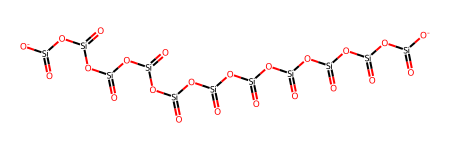

In [203]:
Chem.MolFromSmiles("[O-][Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)O[Si](=O)[O-]")